# Experiments with QUIMB
## Imports

In [1]:
import quimb as qu
from quimb import tensor as qtn
from utils import *

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import torch
from torchinfo import summary
import numpy as np
import scipy as sp
import cupy as cp
import pandas as pd
import string
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Code examples from quimb official site

In [5]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

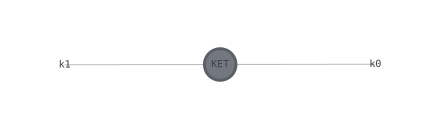

In [22]:
ket.draw()

In [23]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])
X

Tensor(shape=(2, 2), inds=('k0', 'b0'), tags=oset(['PAULI', 'X', '0']))

In [24]:
TN = ket.H & X & Y & bra
TN

TensorNetwork(tensors=4, indices=4)

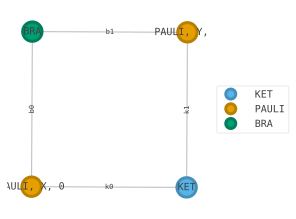

In [ ]:
TN.draw(color=['KET', 'PAULI', 'BRA'], figsize=(4, 4), show_inds='all')

In [25]:
TN ^ ...

(0.027295809086150133+0.2762115381581639j)

## Let's try to build a TTN

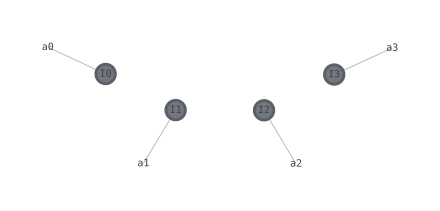

In [38]:
# generating a random MPS

ket_mps = qtn.MPS_rand_state(4, 1, site_ind_id='a{}')
ket_mps.draw()

In [39]:
ket_mps

MatrixProductState(tensors=4, indices=7, L=4, max_bond=2)

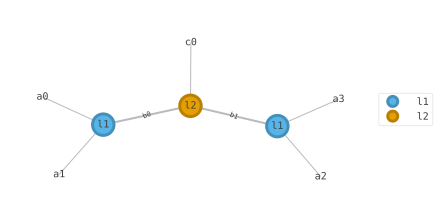

TensorNetwork(tensors=3, indices=7)

In [27]:
T1 = qtn.rand_tensor((2,2,4), inds=('a0', 'a1', 'b0'), tags=['l1'])
T2 = qtn.rand_tensor((2,2,4), inds=('a2', 'a3', 'b1'), tags=['l1'])
T3 = qtn.rand_tensor((4, 4, 2), inds=('b0', 'b1', 'c0'), tags=['l2'])

TN = T1 & T2 & T3
TN.draw(color=['l1', 'l2'], show_inds='all')
TN

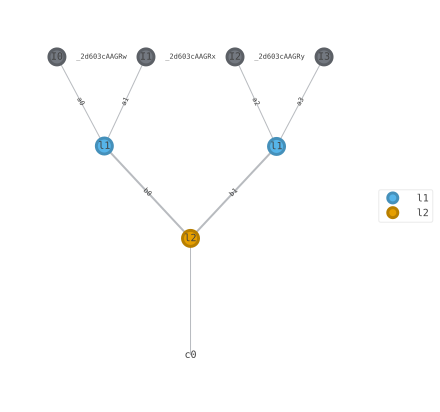

In [28]:
(TN & ket_mps).draw(color=['l1', 'l2'], show_inds='all', fix={'I{}'.format(i): (i, 5) for i in range(4)} )

In [29]:
contr = (TN & ket_mps).contract(..., backend='cupy')

In [31]:
contr.data

array([-4.49300185, -0.65061172])

# Try a TTN on MNIST

## Preprocess

In [4]:
import torchvision as tv

h = 8

def linearize(tensor: torch.Tensor):

    result = torch.clone(tensor).reshape((-1, np.prod(tensor.shape[-2:])))
    index = torch.as_tensor(range(result.shape[-1]))
    mask = index // 2 % 2 == 0

    for i in range(tensor.shape[-1]):
        result[:, (mask != i%2) & (index < (i//2+1)*2*tensor.shape[-1]) & (index >= (i//2)*2*tensor.shape[-1])]= tensor[:,i,:]

    return result

def quantize(tensor):

    cos = np.cos(np.pi*tensor/2)
    sin = np.sin(np.pi*tensor/2)

    return np.stack([cos, sin], axis=-1)


transform = tv.transforms.Compose([tv.transforms.Resize((h, h)), 
                                   tv.transforms.ToTensor(), 
                                   tv.transforms.Lambda(linearize), 
                                   tv.transforms.Lambda(quantize)]
            )


mnist_test  = tv.datasets.MNIST('data', download=True, train=False, transform=transform)
mnist_train = tv.datasets.MNIST('data', download=True, train=True, transform=transform)

In [5]:
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=64)

In [6]:
next(iter(train_dl))[0]

tensor([[[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000]]],


        [[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000]]],


        [[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [0.9999, 0.0123],
          ...,
          [1.0000, 0.0000],
          [1.0000, 0.0062],
          [1.0000, 0.0000]]],


        ...,


        [[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000]]],


        [[[1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          ...,
          [1.0000, 0.0000],
          [1.0000, 0.0000],
          [1.0000, 0.0000]]],


        [[[1.0000, 0.0000],
          [1.0000, 0.0

In [13]:
def norm_fn(tn : qtn.TensorNetwork):
    return tn.isometrize(method="cayley")

## Define model

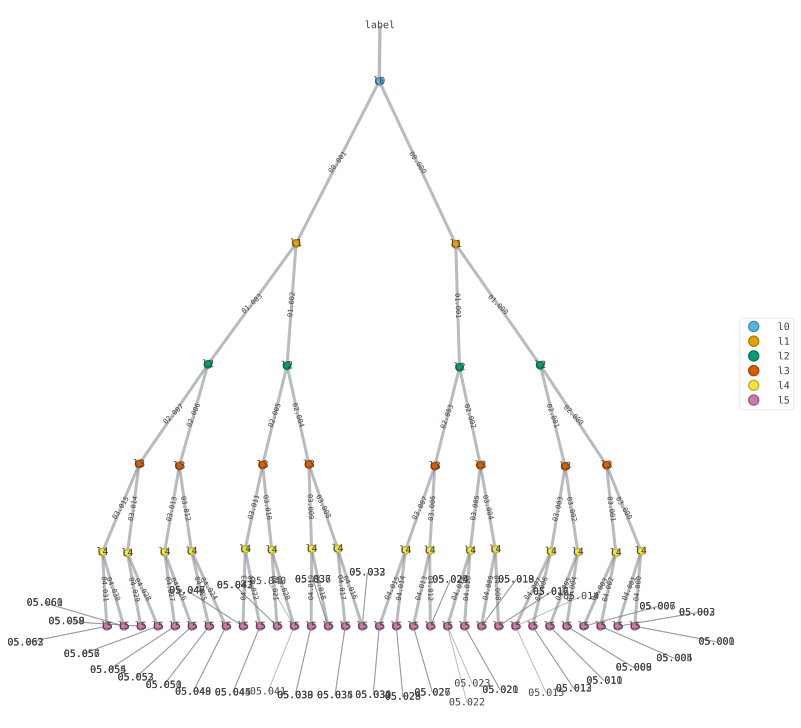

Layer (type:depth-idx)                   Output Shape              Param #
TNModel                                  [64, 10]                  17,024
Total params: 17,024
Trainable params: 17,024
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.13
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.13

In [7]:
MyTTN = TTN(h**2, n_labels=10, bond_dim=8)
model = TNModel(MyTTN)
model.draw()
summary(model, input_size=next(iter(train_dl))[0].shape, dtypes=[torch.complex128])

In [8]:
def th_nparams(ttn):
    return ttn.n_features*2*ttn.bond_dim+ttn.bond_dim**3*2*(2**(ttn.n_hlayers-1)-1)+ttn.bond_dim**2*ttn.n_labels
'''
def th_nparams_v2(ttn):
    tensor_dict = ttn.net.get_params()
    result = 0

    for tensor in tensor_dict.values():
        result += np.prod(tensor.shape)
    return result
'''

th_nparams(MyTTN)

17024

## Training with pytorch

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters())

In [10]:

def train_one_epoch(model, train_dl):
    running_loss = 0.
    last_loss = 0.
    last_batch = 0
    loss_history = []

    model.to('cuda')

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    pbar = tqdm(enumerate(train_dl), total=len(train_dl),position=0)
    for i, data in pbar:

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to('cuda', dtype=torch.complex128), labels.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.abs(outputs).to('cpu')

        # Compute the loss and its gradients
        loss = loss_fn(torch.nn.functional.one_hot(labels).to('cpu',dtype=torch.float64), probs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        loss_history.append(loss.item())
        if i % 10 == 9:
            last_batch = i+1
            last_loss = running_loss / 10 # loss per batch
            running_loss = 0.
           
        pbar.set_postfix({'current loss': loss.item(), f'batch {last_batch} loss': last_loss})
    return loss_history


In [40]:
model.train()
loss_history = train_one_epoch(model, train_dl)

  0%|          | 0/938 [00:00<?, ?it/s]

In [41]:
torch.save(model.state_dict, 'trainedmodel64.dict')

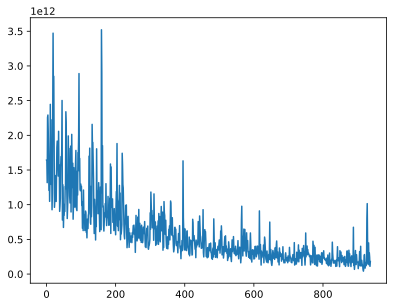

In [44]:
plt.plot(range(len(train_dl)), loss_history)

In [62]:
with torch.no_grad():
    model.eval()
    inputs, labels = next(iter(train_dl))
    result = model(inputs.to('cuda', dtype=torch.complex128))

probs = torch.abs(result).to('cpu')

# Compute the loss and its gradients
loss = loss_fn(torch.nn.functional.one_hot(labels).to('cpu',dtype=torch.float64), probs)
loss

## Training with quimb

In [17]:
tnopt = qtn.TNOptimizer(
    # the tensor network we want to optimize
    MyTTN.net,
    # the functions specfying the loss and normalization
    loss_fn=loss_fn,
    #norm_fn=norm_fn,
    # we specify constants so that the arguments can be converted
    # to the  desired autodiff backend automatically
    #loss_constants={"ham": ham},
    # the underlying algorithm to use for the optimization
    # 'l-bfgs-b' is the default and often good for fast initial progress
    optimizer="adam",
    autodiff_backend="torch",
)
tnopt

<TNOptimizer(d=34048, backend=torch)>

In [18]:
tnopt.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: CrossEntropyLoss.forward() missing 1 required positional argument: 'target'

# Try TTN on Titanic dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

dataset = pd.read_csv('../data/titanic.csv')
data_trimmed = dataset.drop(['Name', 'Ticket'], axis=1).copy()

In [5]:
def convert_single_cab(cab):
    result = 0
    num_pow = 0
    alpha_pow = 3
    if pd.isna(cab): return 0
    else:
        for char in cab[::-1]:
            if char.isdigit():
                result += 10**num_pow*int(char)
                num_pow += 1
            elif char.isalpha():
                result += 10**alpha_pow*(string.ascii_uppercase.index(char)+1)
            elif char.isspace():
                continue
            else:
                print('Error converting cabin number')
                return None
        return result
    
def convert_cabs(cabs):
    if pd.isna(cabs): return 0
    else: return np.mean(list(map(convert_single_cab, cabs.split())))

miao = data_trimmed['Cabin'].apply(convert_cabs)

In [6]:
class TitanicDataset(Dataset):
    def __init__(self, filepath, transform=None):
        self.data = pd.read_csv(filepath)
    
        # convert to numerical
        self.data['Cabin_num'] = self.data['Cabin'].apply(convert_cabs)
        self.data['Sex_num'] = pd.Categorical(self.data['Sex']).codes
        self.data['Embarked_num'] = pd.Categorical(self.data['Embarked']).codes

        #trim useless columns
        self.data = self.data.drop(['PassengerId', 'Name', 'Sex', 'Cabin', 'Embarked', 'Ticket'], axis=1).dropna(axis=0).copy()

        self.transform = transform
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        label = np.array(self.data.iloc[idx, 0])
        data = np.array(self.data.iloc[idx, 1:])

        if self.transform:
            data = self.transform(data)

        return data, label

In [8]:

titanic_dataset = TitanicDataset('../data/titanic.csv', transform=tv.transforms.Lambda(quantize))

titanic_dl = DataLoader(titanic_dataset, batch_size=64)

In [9]:
datum = next(iter(titanic_dl))[0]
datum.shape

torch.Size([64, 8, 2])

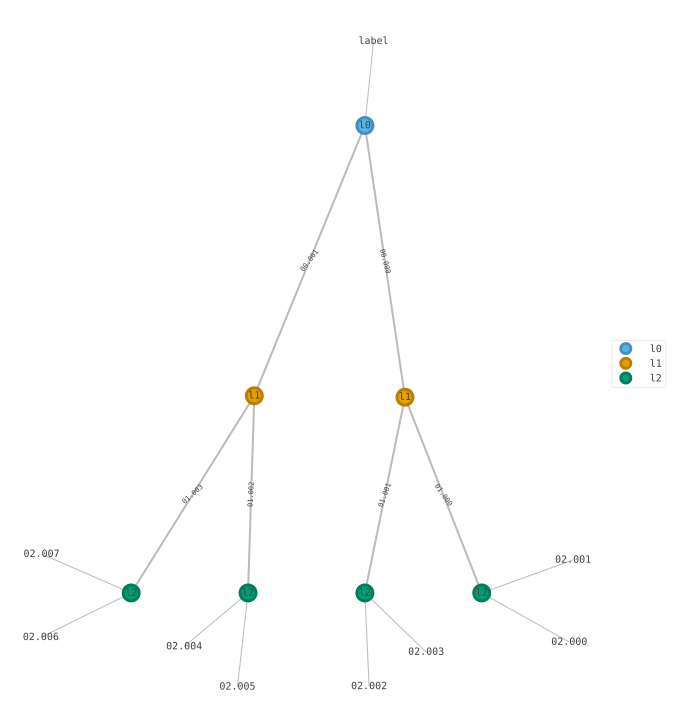

In [10]:
titanic_TTN = TTN(8)
titanic_model = TNModel(titanic_TTN)
titanic_model.draw()

In [11]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(titanic_model.parameters())

In [14]:
titanic_model.train()
train_one_epoch(titanic_model, titanic_dl)

  0%|          | 0/12 [00:00<?, ?it/s]

[-98.08844112977505, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]